In [0]:
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mplt
import seaborn as sns

import PIL
import math
import xml.etree as et

from collections import OrderedDict

from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [0]:
dir_name = 'images'
data_dir = Path(f'data/{dir_name}')
model_dir = Path(f'model/{dir_name}')

In [0]:
import urllib.request
import tarfile

initial_run = not os.path.exists(str(model_dir))

if initial_run:
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(data_dir, exist_ok=True)
    data_url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar'
    download_file = 'data.tar'
    urllib.request.urlretrieve(data_url, f'{data_dir/download_file}')
    download_file = 'data.tar'
    with tarfile.TarFile(data_dir/download_file, 'r') as tar_archive:
        tar_archive.extractall(data_dir)
else:
  pass

In [0]:
# Label map
voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

# a dictionary for the labels {'background': 0,'aeroplane': 1, bicycle: 2, etc...}
label_map = {key: val + 1 for val, key in enumerate(voc_labels)}

label_map['background'] = 0 # could be a good feature

# and the inverse {0: 'background', etc...}
inverse_label_map = {val: key for key, val in label_map.items()}

In [0]:
img_folder = 'VOCdevkit/VOC2012/JPEGImages'
anno_folder = 'VOCdevkit/VOC2012/Annotations'

In [0]:
cols = ['Name', 'Annotation', 'Image', 'Width', 'Height', 'Object_Qty', 'Label', 'Bound_Box', 'Image_Path']

In [0]:
def read_annotation(file_name):
    tree = et.ElementTree.parse(file_name)
    root = tree.getroot()

    boxes = []
    labels = []
    difficulties = []

    for item in root.iter('object'):
        difficult = int(item.find('difficult').text == '1')

        label = item.find('name').text.lower().strip()
        if label not in label_map:
            continue

        bbox = item.find('bndbox')
        xmin = int(float(bbox.find('xmin').text)) - 1
        ymin = int(float(bbox.find('ymin').text)) - 1
        xmax = int(float(bbox.find('xmax').text)) - 1
        ymax = int(float(bbox.find('ymax').text)) - 1

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_map[label])
        difficulties.append(difficult)

    return boxes, labels, difficulties

In [0]:
def read_image(cols, folder):
    file_list = [name[:-4] for name in list(os.listdir(data_dir/folder))]
    image_df = pd.DataFrame(columns=cols)
    image_df['Name'] = file_list
    image_df['Image'] = image_df['Name'] + '.jpg'
    image_df['Annotation'] = image_df['Name'] + '.xml'
    image_df['Image_Path'] = str(data_dir/folder) + '/' + image_df['Image']

    return image_df

In [0]:
def image_dataframe(cols, img_path, anno_path):
    image_df = pd.DataFrame(columns=cols)
    image_df = image_df.append(read_image(cols, img_path), ignore_index=True)
    
    for row in range(image_df.shape[0]):
        img_dims = PIL.Image.open(image_df.iloc[row]['Image_Path']).size
        image_df.iloc[row]['Width'] = img_dims[0]
        image_df.iloc[row]['Height'] = img_dims[1]

        img_annos = read_annotation(str(data_dir/anno_path) + '/' + image_df.iloc[row]['Annotation'])
        image_df.iloc[row]['Bound_Box'] = img_annos[0]
        image_df.iloc[row]['Label'] = img_annos[1]
        # image_df.iloc[row]['Difficulty'] = img_annos[2]
        image_df.iloc[row]['Object_Qty'] = len(img_annos[1])
    
    return image_df

In [0]:
raw_df = image_dataframe(cols, img_path=img_folder, anno_path=anno_folder)

In [0]:
## Limiting dataframe to images with only one object present
#######################################################image_df = raw_df[raw_df['Object_Qty'] < 2].copy().reset_index(drop=True)
image_df = raw_df.copy().reset_index(drop=True)

In [0]:
# Adding calculated columns in the dataframe
image_df['Class_ID'] = [element[0] for element in image_df['Label']]
image_df['Class_Name'] = image_df['Class_ID'].map(inverse_label_map)

image_df['xmin'] = [element[0][0] for element in image_df['Bound_Box']]
image_df['ymin'] = [element[0][1] for element in image_df['Bound_Box']]
image_df['xmax'] = [element[0][2] for element in image_df['Bound_Box']]
image_df['ymax'] = [element[0][3] for element in image_df['Bound_Box']]

image_df['xmin_pct'] = image_df['xmin'] / image_df['Width']
image_df['ymin_pct'] = image_df['ymin'] / image_df['Height']
image_df['xmax_pct'] = image_df['xmax'] / image_df['Width']
image_df['ymax_pct'] = image_df['ymax'] / image_df['Height']

image_df['object_width'] = image_df['xmax_pct'] - image_df['xmin_pct']
image_df['object_height'] = image_df['ymax_pct'] - image_df['ymin_pct']

In [0]:
# Changing data types for columns in the dataframe
float_cols = ['xmin_pct', 'ymin_pct', 'xmax_pct', 'ymax_pct', 'object_width', 'object_height']
image_df[float_cols] = image_df[float_cols].astype('float64')

int_cols = ['Width', 'Height', 'Object_Qty']
image_df[int_cols] = image_df[int_cols].astype('int64')

In [0]:
# Removing surplus columns in the dataframe
remove_cols = ['Annotation', 'Image', 'Label', 'Bound_Box']
image_df.drop(remove_cols, axis=1, inplace=True)

In [0]:
def data_split(data, save_data=True, load_data=True):
    # Data split part
    train_data, testval_data = train_test_split(data, test_size=0.2, random_state=10, stratify=data[target_col])
    val_data, test_data = train_test_split(testval_data, test_size=0.5, random_state=10, stratify=testval_data[target_col])

    # Setting variables
    file_contents = [train_data, val_data, test_data]
    file_names = ['train_data.csv', 'val_data.csv', 'test_data.csv']

    # Reseting indices on data
    for contents in file_contents:
        contents.reset_index(drop=True, inplace=True)

    # Saving data to csv files
    if save_data:
        for name, contents in zip(file_names, file_contents):
            contents.to_csv(path_or_buf=data_dir/name, index=False, header=True)
    
    # Loading data from csv files
    if load_data:
        for name, contents in zip(file_names, file_contents):
            contents = pd.read_csv(data_dir/name, low_memory=False)
    
    return train_data, val_data, test_data

In [0]:
target_col = 'Class_ID'
image_path_col = 'Image_Path'
bndbox_cols = ['ymin_pct', 'xmin_pct', 'ymax_pct', 'xmax_pct']

work_data = image_df.copy()

In [0]:
# Spliting data into train, validation and test sets
train_data, val_data, test_data = data_split(work_data)

In [0]:
# Checking the shapes of splited data
[x.shape for x in (train_data, val_data, test_data)]

[(13700, 17), (1712, 17), (1713, 17)]

In [0]:
# decomposing an image into its constituent visual patterns
def image_parse(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=IMG_CHANNELS)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    return image

In [0]:
def image_resize(image, img_dims):
    image = tf.image.resize(image, img_dims)
    
    return image

In [0]:
def image_augment(image, level=0):
    if level > 0:
        if level > 5:
            level = 5
        
        delta = 0.1 * level
        lower = 1 - delta
        upper = 1 + delta
        image = tf.image.random_contrast(image, lower=lower, upper=upper)
        image = tf.image.random_saturation(image, lower=lower, upper=upper)
        image = tf.image.random_brightness(image, max_delta=delta)
        image = tf.image.random_hue(image, max_delta=delta)
        image = tf.clip_by_value(image, 0.0, 1.0)

    return image

In [0]:
def prepare_ds(
    df,
    x,
    y,
    batch_size,
    image_size,
    image_aug_level,
    prefetch=1,
    shuffle=False,
    num_parallel_calls=1,
):
    filenames = np.array([f"{getattr(row, x)}" for row in df.itertuples()])
    labels = tuple(
        [
            tf.cast(df[y[0]].values, tf.float32),
            tf.cast(df[y[1]].values, tf.float32),
        ]
    )
    dataset_length = len(filenames)

    parse_fn = partial(image_parse)
    resize_fn = partial(image_resize, img_dims=(image_size, image_size))
    augment_fn = partial(image_augment, level=image_aug_level)

    image_ds = (
        tf.data.Dataset.from_tensor_slices(filenames)
        .map(parse_fn, num_parallel_calls=num_parallel_calls)
        .map(resize_fn, num_parallel_calls=num_parallel_calls)
        .map(augment_fn, num_parallel_calls=num_parallel_calls)
     )
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    
    dataset = tf.data.Dataset.zip((image_ds, label_ds))

    if shuffle:
        dataset = dataset.shuffle(dataset_length)

    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    if prefetch:
        dataset = dataset.prefetch(prefetch)
    return dataset, dataset_length, batch_size

In [0]:
BATCH_SIZE = 32
IMG_SIZE = 299
IMG_CHANNELS = 3
IMG_AUG_LEVEL = 3

In [0]:
train_dataset, train_dataset_length, train_batch_size = prepare_ds(
    df=train_data,
    x=image_path_col,
    y=[target_col, bndbox_cols],
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    image_aug_level=IMG_AUG_LEVEL,
    shuffle=True,
    prefetch=1,
    num_parallel_calls=-1,
)
train_dataset_steps = math.ceil(train_dataset_length / train_batch_size)

In [0]:
train_dataset.element_spec

(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None),
 (TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))

In [0]:
val_dataset, val_dataset_length, val_batch_size = prepare_ds(
    df=val_data,
    x=image_path_col,
    y=[target_col, bndbox_cols],
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    image_aug_level=0,
    shuffle=False,
    prefetch=1,
    num_parallel_calls=-1,
)
val_dataset_steps = math.ceil(val_dataset_length / val_batch_size)

In [0]:
def plot_dataset(dataset, rows, cols):
    _, ax = plt.subplots(rows, cols, figsize=(8 * cols, 8 * rows))
    colors = np.array([[1.0, 0.0, 0.0]])
    for i, (x, y) in enumerate(dataset.take(rows * cols)):
        categories, bounding_boxes = y
        images = tf.image.draw_bounding_boxes(x, tf.expand_dims(bounding_boxes, 1), colors)
        category = categories[0].numpy()
        bounding_box = bounding_boxes[0].numpy()
        ax[i // cols, i % cols].text(
            bounding_box[1] * IMG_SIZE,
            bounding_box[2] * IMG_SIZE,
            inverse_label_map[category].title(),
            backgroundcolor='red',
            fontsize=12,
        )
        ax[i // cols, i % cols].axis('off')
        title = f'Class - {category} ({inverse_label_map[category]})\n Box - {bounding_box[1]:.2}, {bounding_box[0]:.2}, {bounding_box[3]:.2}, {bounding_box[2]:.2}'
        ax[i // cols, i % cols].set_title(title)
        ax[i // cols, i % cols].imshow(images[0])

## *Data Analysis*

In [0]:
# How many images (pct)
def pct(data):
  total = work_data
  pct = round(len(data)/len(total)*100)
  return str(pct)+'%'


print(f'''Split the data into 
train : val : test = {pct(train_data)} : {pct(val_data)} : {pct(test_data)}''')
print("")

print(f'Total Images : {len(work_data)}')
print("")

print(f'Total Images in the train: {len(train_data)}')
print(f'Total Images in the val: {len(val_data)}')
print(f'Total Images in the test: {len(test_data)}')

Split the data into 
train : val : test = 80% : 10% : 10%

Total Images : 17125

Total Images in the train: 13700
Total Images in the val: 1712
Total Images in the test: 1713


In [0]:
print(f"Image dimensions vary from {image_df['Height'].min()} to {image_df['Height'].max()} pixels in height.")
print(f"And from {image_df['Width'].min()} to {image_df['Width'].max()} pixels in width.")

Image dimensions vary from 71 to 500 pixels in height.
And from 142 to 500 pixels in width.


In [0]:
# Number of Classes
class_num = image_df[target_col].nunique() ; class_num

20

In [0]:
# Value count by Class in whole data
image_df[target_col].value_counts().sort_values(ascending=False)

15    6890
12    1204
8     1047
7      785
3      767
1      683
9      547
19     533
13     465
4      462
2      449
20     439
14     431
6      405
18     392
5      391
17     344
10     326
11     287
16     278
Name: Class_ID, dtype: int64

In [0]:
target_col = 'Class_Name' ; record_col = 'Name'

In [0]:
def bar_plot(data_df, feature, target):
    # counting feature instances by target class
    class_df = data_df[[feature, target]].groupby(target, as_index=False).count()
    class_df = class_df.sort_values(by=record_col, ascending=False).reset_index(drop=True)
    order_labels = list(class_df[target_col])

    # setting plot style & size
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 0.75 * class_df[target].nunique()))

    # highlight top 5
    def kth_largest_number(arr, K):
        unique_nums = set(arr)
        sorted_nums = sorted(unique_nums, reverse=True)
        return sorted_nums[K-1]
    
    values = class_df[feature]
    colors=['black' if (x < kth_largest_number(values,5)) else 'red' for x in values]

    # rendering plot
    sns.barplot(x=feature, y=target, data=class_df, edgecolor=colors, orient='h', order=order_labels)

    # adding chart title
    def get_df_name(data_df):
      name = [x for x in globals() if globals()[x] is data_df][0]
      return name
    
    plt.title('Number of Records per Class in '+ get_df_name(data_df), size=14)

    # adding custom labels for axes
    plt.ylabel('Class')
    plt.xlabel('# of Records')

    # adding labels on data points
    for index, row in class_df.iterrows():
        plt.text(row[feature] + class_df[feature].max() * 0.05, index, f'{row[feature]}', color='black', ha="center", size=11)

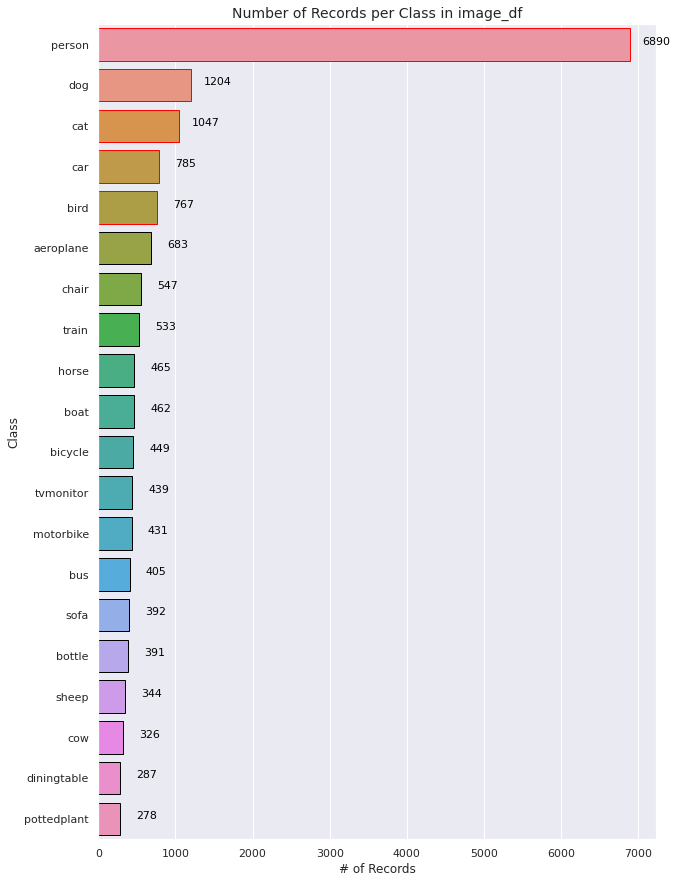

In [0]:
# bar plots for whole data
bar_plot(image_df, record_col, target_col)

(None, None, None)

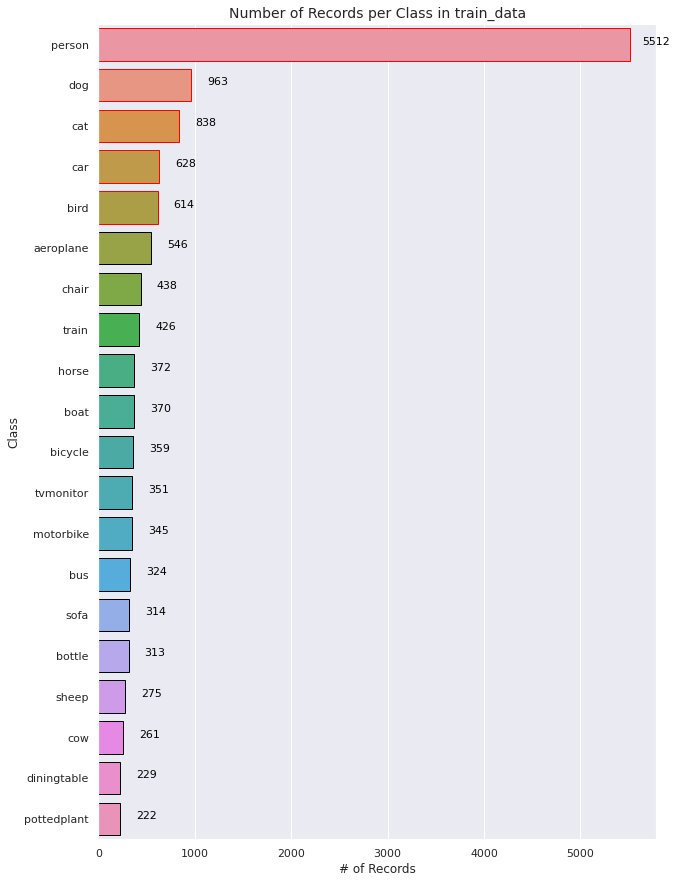

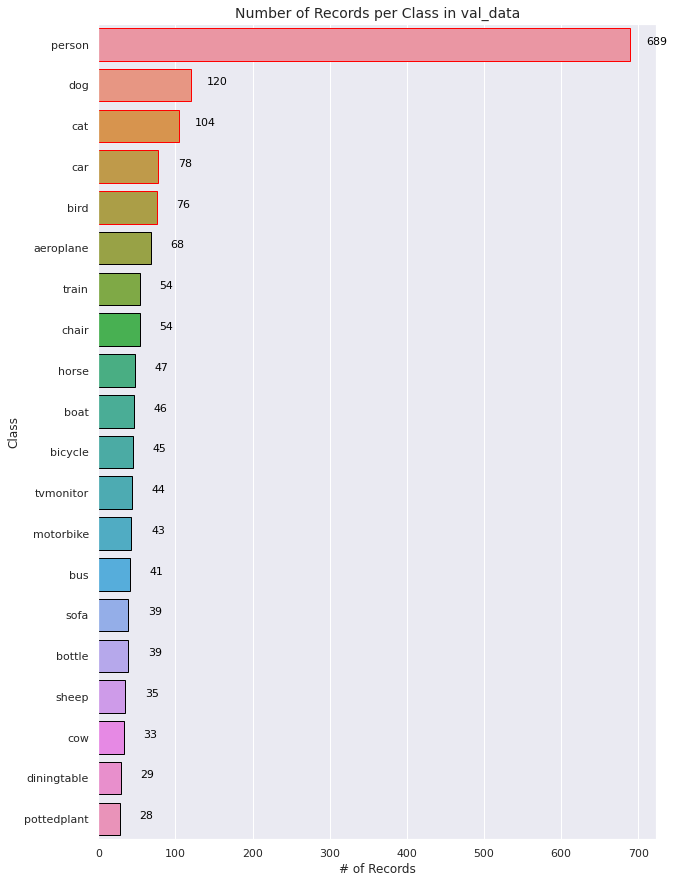

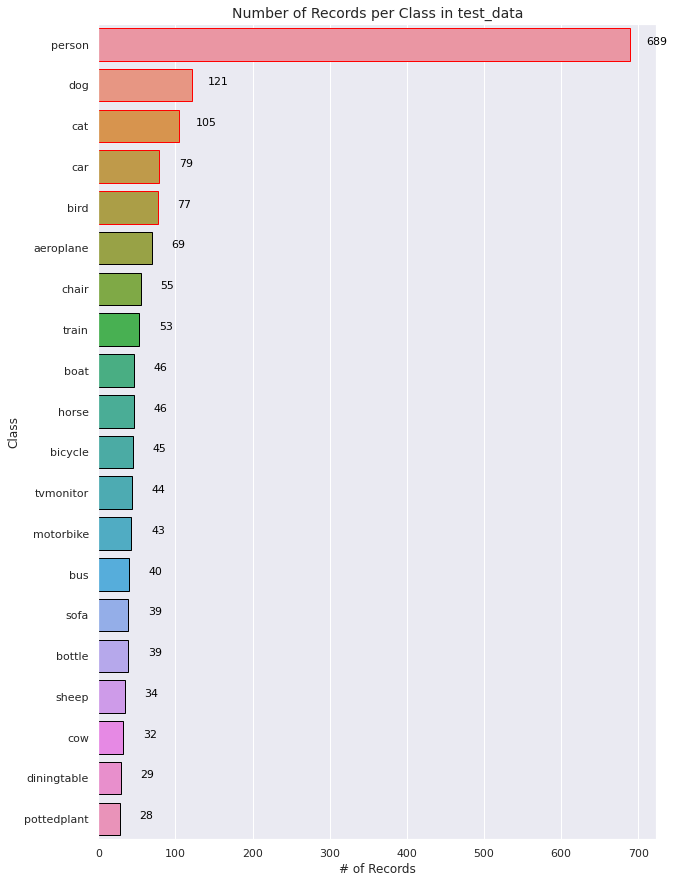

In [0]:
# bar plots for each data
bar_plot(train_data, record_col, target_col), bar_plot(val_data, record_col, target_col), bar_plot(test_data, record_col, target_col)

Text(0, 0.5, '# of Records')

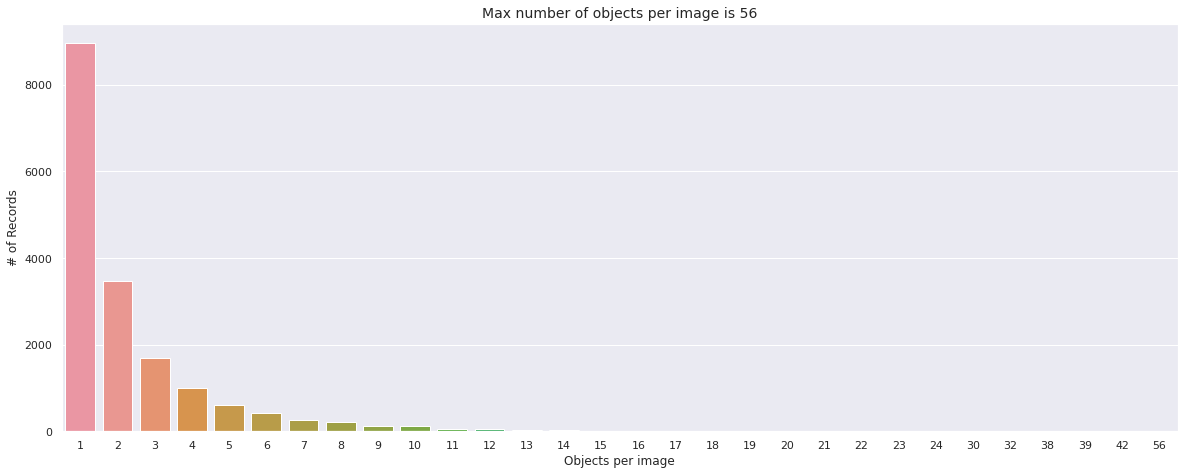

In [0]:
#Histogram of the number of objects per image
plt.figure(figsize=(20, 0.25 * image_df['Object_Qty'].nunique()))
sns.countplot(data=image_df, x = 'Object_Qty')
plt.title('Max number of objects per image is {0}'.format(image_df['Object_Qty'].max()), size=14)
plt.xlabel('Objects per image')
plt.ylabel('# of Records')

## Drawing bounding box
(for image with max number of objects)

In [0]:
from google.colab import drive 
drive.mount('/content/drive/')

path = '/content/drive/My Drive/G10_Object_Localisation/VOCdevkit/VOC2012/'
anno = path + 'Annotations'
image = path + 'JPEGImages'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
def extract_annotation2(tree):
  number_of_objects = 0
  image = {}
  for elem in tree.iter():
    if elem.tag == "size":
      for el in elem:
        image[el.tag] = int(el.text)
    if elem.tag == "object":
      for box in elem:
        if box.tag == "name":
          image["Obj{}_{}".format(number_of_objects,box.tag)]=str(box.text)
        if box.tag == "bndbox":
          for i in box:
            image["Obj{}_{}".format(number_of_objects,i.tag)]=float(i.text)
          number_of_objects += 1
  image["number_of_objects"] = number_of_objects
  print('xml annotation file with most lines is {0}.xml'.format(max_object))

  return(image)    

In [0]:
anno_csv = path + 'df_a.csv'
df = pd.read_csv(anno_csv)
print(df.shape)
df.head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200,205,210,215,220,225,230,235,240,245,250,255,260,265,270,275,280) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(17125, 285)


,width,height,depth,Obj0_name,Obj0_xmin,Obj0_ymin,Obj0_xmax,Obj0_ymax,number_of_objects,filename,Obj1_name,Obj1_xmin,Obj1_ymin,Obj1_xmax,Obj1_ymax,Obj2_name,Obj2_xmin,Obj2_ymin,Obj2_xmax,Obj2_ymax,Obj3_name,Obj3_xmin,Obj3_ymin,Obj3_xmax,Obj3_ymax,Obj4_name,Obj4_xmin,Obj4_ymin,Obj4_xmax,Obj4_ymax,Obj5_name,Obj5_xmin,Obj5_ymin,Obj5_xmax,Obj5_ymax,Obj6_name,Obj6_xmin,Obj6_ymin,Obj6_xmax,Obj6_ymax,...,Obj48_name,Obj48_xmin,Obj48_ymin,Obj48_xmax,Obj48_ymax,Obj49_name,Obj49_xmin,Obj49_ymin,Obj49_xmax,Obj49_ymax,Obj50_name,Obj50_xmin,Obj50_ymin,Obj50_xmax,Obj50_ymax,Obj51_name,Obj51_xmin,Obj51_ymin,Obj51_xmax,Obj51_ymax,Obj52_name,Obj52_xmin,Obj52_ymin,Obj52_xmax,Obj52_ymax,Obj53_name,Obj53_xmin,Obj53_ymin,Obj53_xmax,Obj53_ymax,Obj54_name,Obj54_xmin,Obj54_ymin,Obj54_xmax,Obj54_ymax,Obj55_name,Obj55_xmin,Obj55_ymin,Obj55_xmax,Obj55_ymax
0,375,500,3,person,1.0,56.0,375.0,500.0,1,2008_000496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,500,374,3,horse,113.0,144.0,339.0,277.0,2,2008_000499,person,226.0,105.0,287.0,221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,333,500,3,person,23.0,78.0,157.0,467.0,3,2008_000475,person,117.0,82.0,221.0,353.0,person,188.0,120.0,291.0,409.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,500,375,3,chair,247.0,2.0,335.0,132.0,3,2008_000498,chair,321.0,56.0,440.0,196.0,chair,341.0,29.0,419.0,143.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,500,375,3,person,111.0,81.0,315.0,375.0,2,2008_000489,chair,396.0,208.0,500.0,375.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,405,500,3,cat,99.0,18.0,397.0,391.0,2,2008_000502,cat,38.0,182.0,240.0,483.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,375,500,3,person,54.0,167.0,189.0,321.0,4,2008_000473,person,1.0,257.0,345.0,438.0,chair,115.0,241.0,309.0,324.0,chair,87.0,301.0,335.0,458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,500,375,3,person,235.0,60.0,500.0,375.0,2,2008_000511,person,76.0,105.0,237.0,285.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,335,447,3,person,35.0,1.0,309.0,409.0,1,2008_000443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,375

In [0]:
# Finding the largest xml file
import xml.etree.ElementTree as et

max_object = df['filename'][df['number_of_objects'].idxmax()]
extract_annotation2(et.parse(os.path.join(anno,max_object+'.xml')))

xml annotation file with most lines is 2008_007069.xml


{'Obj0_name': 'sheep',
 'Obj0_xmax': 445.0,
 'Obj0_xmin': 411.0,
 'Obj0_ymax': 195.0,
 'Obj0_ymin': 172.0,
 'Obj10_name': 'sheep',
 'Obj10_xmax': 117.0,
 'Obj10_xmin': 99.0,
 'Obj10_ymax': 174.0,
 'Obj10_ymin': 161.0,
 'Obj11_name': 'sheep',
 'Obj11_xmax': 101.0,
 'Obj11_xmin': 84.0,
 'Obj11_ymax': 176.0,
 'Obj11_ymin': 161.0,
 'Obj12_name': 'sheep',
 'Obj12_xmax': 224.0,
 'Obj12_xmin': 208.0,
 'Obj12_ymax': 169.0,
 'Obj12_ymin': 155.0,
 'Obj13_name': 'sheep',
 'Obj13_xmax': 259.0,
 'Obj13_xmin': 238.0,
 'Obj13_ymax': 170.0,
 'Obj13_ymin': 154.0,
 'Obj14_name': 'sheep',
 'Obj14_xmax': 350.0,
 'Obj14_xmin': 330.0,
 'Obj14_ymax': 164.0,
 'Obj14_ymin': 147.0,
 'Obj15_name': 'sheep',
 'Obj15_xmax': 313.0,
 'Obj15_xmin': 301.0,
 'Obj15_ymax': 146.0,
 'Obj15_ymin': 138.0,
 'Obj16_name': 'sheep',
 'Obj16_xmax': 301.0,
 'Obj16_xmin': 290.0,
 'Obj16_ymax': 146.0,
 'Obj16_ymin': 137.0,
 'Obj17_name': 'sheep',
 'Obj17_xmax': 22.0,
 'Obj17_xmin': 1.0,
 'Obj17_ymax': 183.0,
 'Obj17_ymin': 170.0,
 '

In [0]:
# set 'filename' as index
df.set_index("filename", inplace=True)
df.head()

,width,height,depth,Obj0_name,Obj0_xmin,Obj0_ymin,Obj0_xmax,Obj0_ymax,number_of_objects,Obj1_name,Obj1_xmin,Obj1_ymin,Obj1_xmax,Obj1_ymax,Obj2_name,Obj2_xmin,Obj2_ymin,Obj2_xmax,Obj2_ymax,Obj3_name,Obj3_xmin,Obj3_ymin,Obj3_xmax,Obj3_ymax,Obj4_name,Obj4_xmin,Obj4_ymin,Obj4_xmax,Obj4_ymax,Obj5_name,Obj5_xmin,Obj5_ymin,Obj5_xmax,Obj5_ymax,Obj6_name,Obj6_xmin,Obj6_ymin,Obj6_xmax,Obj6_ymax,Obj7_name,...,Obj48_name,Obj48_xmin,Obj48_ymin,Obj48_xmax,Obj48_ymax,Obj49_name,Obj49_xmin,Obj49_ymin,Obj49_xmax,Obj49_ymax,Obj50_name,Obj50_xmin,Obj50_ymin,Obj50_xmax,Obj50_ymax,Obj51_name,Obj51_xmin,Obj51_ymin,Obj51_xmax,Obj51_ymax,Obj52_name,Obj52_xmin,Obj52_ymin,Obj52_xmax,Obj52_ymax,Obj53_name,Obj53_xmin,Obj53_ymin,Obj53_xmax,Obj53_ymax,Obj54_name,Obj54_xmin,Obj54_ymin,Obj54_xmax,Obj54_ymax,Obj55_name,Obj55_xmin,Obj55_ymin,Obj55_xmax,Obj55_ymax
filename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008_000496,375,500,3,person,1.0,56.0,375.0,500.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008_000499,500,374,3,horse,113.0,144.0,339.0,277.0,2,person,226.0,105.0,287.0,221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008_000475,333,500,3,person,23.0,78.0,157.0,467.0,3,person,117.0,82.0,221.0,353.0,person,188.0,120.0,291.0,409.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008_000498,500,375,3,chair,247.0,2.0,335.0,132.0,3,chair,321.0,56.0,440.0,196.0,chair,341.0,29.0,419.0,143.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008_000489,500,375,3,person,111.0,81.0,315.0,375.0,2,chair,396.0,208.0,500.0,375.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
import cv2 
jpgpath = os.path.join(image,max_object+'.jpg')
pic = cv2.imread(jpgpath)

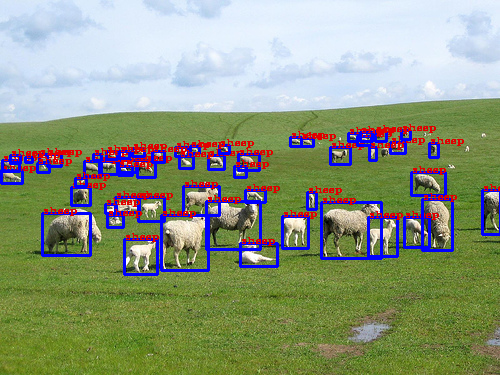

In [0]:
from google.colab.patches import cv2_imshow

# Image which has most objects
# Slice the row

row = df.loc[max_object,:]
for a in range(row['number_of_objects']):
  x1, y1 = int(row["Obj{}_xmin".format(a)]),int(row["Obj{}_ymin".format(a)])
  x2, y2 = int(row["Obj{}_xmax".format(a)]),int(row["Obj{}_ymax".format(a)])
  color = (255,0,0)
  thickness = 2
  font_color = (0,0,225)
  rect = cv2.rectangle(pic,(x1,y1),(x2,y2),color,thickness)
  font = cv2.FONT_HERSHEY_COMPLEX_SMALL
  cv2.putText(pic,row["Obj{}_name".format(a)],(x1,y1),font,0.5,font_color,1)
cv2_imshow(rect)